In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# Define LeNet-5 Architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, 1, 0)  # Output: 28x28x6
        self.pool = nn.AvgPool2d(2, 2)  # Output: 14x14x6
        self.conv2 = nn.Conv2d(6, 16, 5, 1, 0)  # Output: 10x10x16

        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Output: 10 classes (digits 0-9)

        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.dropout2(x)

        x = self.fc3(x) # Softmax applied later in CrossEntropyLoss

        return x

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load dataset (MNIST)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
  ])

In [5]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
# Initialize Model, Loss Function, and Optimizer
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [7]:
# Training Loop
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

Epoch 1/5, Loss: 0.4387
Epoch 2/5, Loss: 0.1831
Epoch 3/5, Loss: 0.1334
Epoch 4/5, Loss: 0.1018
Epoch 5/5, Loss: 0.0922


In [ ]:
# Evaluate Model
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.39%



True Label: 7, 
Predicted Label: 7


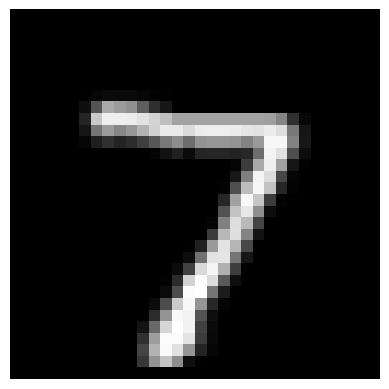

In [9]:
# Set model to evaluation mode
model.eval()
model = model.to(device)

# Get a single image and label from the test loader
test_image, true_label = testset[0]

# Display the image
plt.imshow(test_image.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for MNIST
plt.axis('off')

# Preprocess and predict
test_image = test_image.unsqueeze(0).to(device)  # Add batch dimension
output = model(test_image)
_, predicted = torch.max(output, 1)  # Get the predicted class

# Print the predicted label
print(f"\nTrue Label: {true_label}, \nPredicted Label: {predicted.item()}")

# Show the image
plt.show()